In [1]:
from datetime import date
import requests
import os.path
from os import path
import math
from tletools import TLE
from skyfield.api import Topos, load
import json
import numpy as np
import pandas as pd

DAY = 24*60*60
EARTH_RADIUS = 6371000.0
EARTH_MU = 3.986004418 * 10**14

today = date.today()
#starlink_url = 'http://celestrak.com/NORAD/elements/starlink.txt'
starlink_url = "http://celestrak.com/NORAD/elements/supplemental/starlink.txt"
tle_file = "../data/%s_starlink_supplemental.tle"%today
starlink_file = "../data/%s_starlink_supplemental.json"%today

if not path.exists(tle_file):
    r = requests.get(starlink_url, allow_redirects=True)
    open(tle_file, 'wb').write(r.content)
    print("Fetching",starlink_url )
else:
    print("Using",tle_file)

launches={
    19029:{'version': 0.9,'mission': 0},
    19074:{'version': 1.0,'mission': 1},
    20001:{'version': 1.0,'mission': 2},
    20006:{'version': 1.0,'mission': 3},
    20012:{'version': 1.0,'mission': 4},
    20019:{'version': 1.0,'mission': 5},
    20025:{'version': 1.0,'mission': 6},
    20035:{'version': 1.0,'mission': 7},
    20038:{'version': 1.0,'mission': 8},
}

if not path.exists(starlink_file):

    starlink={}

    with open(tle_file , 'r') as tles:
        lines = tles.readlines()

    objects=int(len(lines)/3)
    #objects=1

    print ("Processing %i objects"%objects)

    for i in range(0,objects*3,3):
        tle_string = ''.join(lines[i:i+3])
        tle_lines = tle_string.strip().splitlines()
        tle = TLE.from_lines(*tle_lines)

        if '-' in tle.name:
            designator=tle.name.split('-')[0]
        else:
            designator=tle.name.split(' ')[0]
        launch=int(tle.int_desig[:5])
        mission=launches[launch]['mission']
        version=launches[launch]['version']
        piece=tle.int_desig[5:]

        if len(piece)==1:
            number=ord(piece)-64
            if number > 8:
               number-=1 

        if len(piece)==2:

            number0=ord(piece[0])-64

            number1=ord(piece[1])-64
            if number1 > 8:
               number1-=1 

            number=number0*25+ number1

        name="%s-%02d%02d"%(designator,mission,number)


        period = DAY / tle.n

        semi_major_axis = (((period / (math.pi*2))**2) * EARTH_MU) ** (1/3)
        ap_plus_pe = semi_major_axis * 2
        ap_minus_pe = tle.ecc * ap_plus_pe
        apogee = (ap_plus_pe + ap_minus_pe) / 2
        perigee = apogee - ap_minus_pe

        apogee -= EARTH_RADIUS
        perigee -= EARTH_RADIUS

        starlink[tle.norad]={'name':name,'mission':mission,'version':version,
                          'apogee':apogee/1000,'perigee':perigee/1000,'period':period/ 60}

    print ("Writing %i objects"%len(starlink),"to",starlink_file)
    with open(starlink_file, 'w') as json_file:
        json.dump(starlink, json_file, indent=4)

else:
    with open(starlink_file) as json_file:
        starlink = json.load(json_file)
    print ("Read",len(starlink),"objects from",starlink_file)


Using ../data/2020-06-19_starlink_supplemental.tle
Read 523 objects from ../data/2020-06-19_starlink_supplemental.json


In [2]:
satellites = load.tle_file(tle_file)
print('Loaded', len(satellites), 'objects')

other=[]
testing=[]
maneuver=[]
station=[]

for sat in satellites:
    satnum=str(sat.model.satnum)
    name=starlink[satnum]['name']
    apogee=starlink[satnum]['apogee']
    perigee=starlink[satnum]['perigee']
    version=starlink[satnum]['version']
    
    if not 'STARLINK' in name:
        other.append(sat)
    else:
    
        if version < 1:
            testing.append(sat)
        else:
            if perigee > 500:
                station.append(sat)
            else:
                maneuver.append(sat)
           
print ("Starlink on station:",len(station))
print ("Starlink manoeuvring:",len(maneuver))
print ("Starlink testing:",len(testing))
print ("Other objects:",len(other))
    

Loaded 523 objects
Starlink on station: 273
Starlink manoeuvring: 197
Starlink testing: 53
Other objects: 0


In [3]:
seattle = Topos('47.6062 N', '122.3321 W')
degrees=25.0

passes_file="../data/%s_seattle.json"%today

ts = load.timescale(builtin=True)
tsn = ts.now()
dtn = tsn.utc_datetime()
dtm = dtn.replace(hour=0,minute=0,second=0, microsecond=0)
dte = dtn.replace(hour=23,minute=59,second=59, microsecond=0)
tsm = ts.utc(dtm)
tse = ts.utc(dte)

if not path.exists(passes_file):

    print ("Calculating Starlink visibility over Seattle at",dtm.strftime('%Y-%m-%d'))

    passes=[]

    for sat in station:
        satnum=str(sat.model.satnum)
        name=starlink[satnum]['name']
        times, events = sat.find_events(seattle, tsm, tse, altitude_degrees=degrees)

        if events[0]==1:
            start=2
        elif events[0]==2:
            start=1
        else:
            start=0

        if events[-1]==0:
            end=len(times)-1
        elif events[-1]==1:
            end=len(times)-2
        else:
            end=len(times)

        for i in range(start,end,3):

            ts_rise = pd.Timestamp(times[i].utc_iso())
            ts_set = pd.Timestamp(times[i+2].utc_iso())
            td_visibile = ts_set-ts_rise

            #print(name,ts_rise.strftime('%H:%M:%S'),ts_set.strftime('%H:%M:%S'),"%.1f"%(td_visibile.seconds/60))

            passes.append({'name':name,'norad':satnum,'rise':times[i].utc_iso(),'set':times[i+2].utc_iso(),"visible":td_visibile.seconds/60})

    print ("Writing %i passes"%len(passes),"to",passes_file)
    with open(passes_file, 'w') as json_file:
            json.dump(passes, json_file, indent=4)
            


In [4]:
passes = pd.read_json(passes_file, convert_dates=['rise','set'])
print(passes)

               name  norad                      rise  \
0     STARLINK-0101  44713 2020-06-19 07:08:36+00:00   
1     STARLINK-0101  44713 2020-06-19 08:48:27+00:00   
2     STARLINK-0101  44713 2020-06-19 10:28:48+00:00   
3     STARLINK-0101  44713 2020-06-19 12:08:16+00:00   
4     STARLINK-0102  44714 2020-06-19 06:44:10+00:00   
...             ...    ...                       ...   
1233  STARLINK-0662  45590 2020-06-19 01:45:57+00:00   
1234  STARLINK-0662  45590 2020-06-19 03:25:37+00:00   
1235  STARLINK-0662  45590 2020-06-19 05:06:02+00:00   
1236  STARLINK-0662  45590 2020-06-19 06:45:31+00:00   
1237  STARLINK-0662  45590 2020-06-19 08:26:42+00:00   

                           set   visible  
0    2020-06-19 07:13:03+00:00  4.450000  
1    2020-06-19 08:52:36+00:00  4.150000  
2    2020-06-19 10:32:32+00:00  3.733333  
3    2020-06-19 12:12:58+00:00  4.700000  
4    2020-06-19 06:47:53+00:00  3.716667  
...                        ...       ...  
1233 2020-06-19 01:50:15+0

In [5]:
rise_count = passes.rise.value_counts()
set_count = passes.set.value_counts()
df2 = pd.concat([rise_count, set_count], axis=1, keys=["rises", "sets","name"],sort=True)
df2.fillna(0, inplace=True)
print (df2)

                           rises  sets
2020-06-19 00:03:08+00:00    1.0   0.0
2020-06-19 00:03:48+00:00    1.0   0.0
2020-06-19 00:04:58+00:00    1.0   0.0
2020-06-19 00:06:55+00:00    0.0   1.0
2020-06-19 00:07:54+00:00    1.0   0.0
...                          ...   ...
2020-06-19 23:53:34+00:00    1.0   0.0
2020-06-19 23:54:35+00:00    1.0   0.0
2020-06-19 23:56:33+00:00    0.0   1.0
2020-06-19 23:56:40+00:00    0.0   1.0
2020-06-19 23:58:18+00:00    0.0   1.0

[2462 rows x 2 columns]


In [6]:
df2["diff"] = df2["rises"] - df2["sets"]
print(df2)

                           rises  sets  diff
2020-06-19 00:03:08+00:00    1.0   0.0   1.0
2020-06-19 00:03:48+00:00    1.0   0.0   1.0
2020-06-19 00:04:58+00:00    1.0   0.0   1.0
2020-06-19 00:06:55+00:00    0.0   1.0  -1.0
2020-06-19 00:07:54+00:00    1.0   0.0   1.0
...                          ...   ...   ...
2020-06-19 23:53:34+00:00    1.0   0.0   1.0
2020-06-19 23:54:35+00:00    1.0   0.0   1.0
2020-06-19 23:56:33+00:00    0.0   1.0  -1.0
2020-06-19 23:56:40+00:00    0.0   1.0  -1.0
2020-06-19 23:58:18+00:00    0.0   1.0  -1.0

[2462 rows x 3 columns]


In [7]:
counts = df2["diff"].resample("5min").sum().fillna(0).cumsum()
print(counts)

2020-06-19 00:00:00+00:00    3.0
2020-06-19 00:05:00+00:00    4.0
2020-06-19 00:10:00+00:00    2.0
2020-06-19 00:15:00+00:00    2.0
2020-06-19 00:20:00+00:00    3.0
                            ... 
2020-06-19 23:35:00+00:00    3.0
2020-06-19 23:40:00+00:00    3.0
2020-06-19 23:45:00+00:00    3.0
2020-06-19 23:50:00+00:00    3.0
2020-06-19 23:55:00+00:00    0.0
Freq: 5T, Name: diff, Length: 288, dtype: float64


/usr/lib64/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


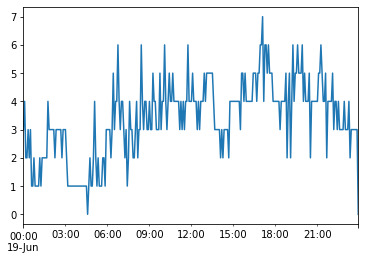

In [8]:
counts.plot()

In [9]:
counts30 = df2["diff"].resample("30min").sum().fillna(0).cumsum()
print(counts30)

2020-06-19 00:00:00+00:00    2.0
2020-06-19 00:30:00+00:00    1.0
2020-06-19 01:00:00+00:00    2.0
2020-06-19 01:30:00+00:00    3.0
2020-06-19 02:00:00+00:00    3.0
2020-06-19 02:30:00+00:00    3.0
2020-06-19 03:00:00+00:00    1.0
2020-06-19 03:30:00+00:00    1.0
2020-06-19 04:00:00+00:00    1.0
2020-06-19 04:30:00+00:00    1.0
2020-06-19 05:00:00+00:00    1.0
2020-06-19 05:30:00+00:00    3.0
2020-06-19 06:00:00+00:00    5.0
2020-06-19 06:30:00+00:00    3.0
2020-06-19 07:00:00+00:00    1.0
2020-06-19 07:30:00+00:00    2.0
2020-06-19 08:00:00+00:00    6.0
2020-06-19 08:30:00+00:00    3.0
2020-06-19 09:00:00+00:00    4.0
2020-06-19 09:30:00+00:00    4.0
2020-06-19 10:00:00+00:00    5.0
2020-06-19 10:30:00+00:00    4.0
2020-06-19 11:00:00+00:00    4.0
2020-06-19 11:30:00+00:00    4.0
2020-06-19 12:00:00+00:00    3.0
2020-06-19 12:30:00+00:00    5.0
2020-06-19 13:00:00+00:00    5.0
2020-06-19 13:30:00+00:00    3.0
2020-06-19 14:00:00+00:00    3.0
2020-06-19 14:30:00+00:00    4.0
2020-06-19